In [1]:
import pandas as pd
import numpy as np


In [26]:
df = pd.read_csv('../results/wikitq_image_0_999_5.csv')

In [27]:
df.score.sum()

np.int64(478)

In [34]:
df = pd.read_csv('../results/wikitq_image_t30_0_999.csv')
df.score.sum()

np.int64(482)

In [44]:
from datasets import load_dataset
df2 = load_dataset('stanford/wikitablequestions', split='test', trust_remote_code=True).to_pandas()

In [47]:
df2.answers.apply(lambda x: len(x)).mean()

np.float64(1.0676795580110496)

In [36]:
df_test = pd.read_json("hf://datasets/TableQAKit/WTQ/test.json")

/root/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
df_test.head(100)

,id,question,table_id,table,answer_text,struct_in,text_in,seq_out
0,nu-0,which country had the most cyclists finish wit...,csv/203-csv/733.csv,"{'header': ['Rank', 'Cyclist', 'Team', 'Time',...",[Italy],col : rank | cyclist | team | time | uci proto...,which country had the most cyclists finish wit...,italy
1,nu-1,how many people were murdered in 1940/41?,csv/204-csv/149.csv,"{'header': ['Description Losses', '1939/40', '...","[100,000]",col : description losses | 1939/40 | 1940/41 |...,how many people were murdered in 1940/41?,"100,000"
2,nu-2,how long did it take for the new york american...,csv/203-csv/435.csv,"{'header': ['Year', 'Division', 'League', 'Reg...",[17 years],col : year | division | league | reg. season |...,how long did it take for the new york american...,17 years
3,nu-3,alfie's birthday party aired on january 19. wh...,csv/204-csv/803.csv,"{'header': ['Series #', 'Season #', 'Title', '...","[January 26, 1995]",col : series # | season # | title | notes | or...,alfie's birthday party aired on january 19. wh...,"january 26, 1995"
4,nu-4,what is the number of 1st place finishes acros...,csv/204-csv/272.csv,"{'header': ['Date', 'Competition', 'Location',...",[17],col : date | competition | location | country ...,what is the number of 1st place finishes acros...,17
...,...,...,...,...,...,...,...,...
95,nu-95,what is the total number of wins listed for th...,csv/204-csv/369.csv,"{'header': ['Golfer', 'Country', 'Wins', 'Matc...",[22],col : golfer | country | wins | match play | c...,what is the total number of wins listed for th...,22
96,nu-96,if italy and brazil combined box office revenu...,csv/203-csv/448.csv,"{'header': ['Rank', 'Country', 'Box Office', '...",[$1.56 billion],col : rank | country | box office | year | box...,if italy and brazil combined box office revenu...,$1.56 billion
97,nu-97,"when did the restaurant ""verre"" at the hilton ...",csv/202-csv/93.csv,"{'header': ['Restaurant', 'Location', 'Date Op...",[October 2011],col : restaurant | location | date opened | da...,"when did the restaurant ""verre"" at the hilton ...",october 2011
98,nu-98,who finished immediately after danny osborne?,csv/204-csv/955.csv,"{'header': ['Position', 'Driver', 'No.', 'Car'...",[Mike Imrie],col : position | driver | no. | car | entrant ...,who finished immediately after danny osborne?,mike imrie


In [85]:
tabfact = load_dataset('ibm/tab_fact', split='test', trust_remote_code=True).to_pandas()

Generating train split: 92283 examples [00:06, 13792.95 examples/s]
Generating validation split: 12792 examples [00:00, 16079.46 examples/s]
Generating test split: 12779 examples [00:00, 16327.01 examples/s]


In [88]:
tabfact_dict = load_dataset('ibm/tab_fact', split='test', trust_remote_code=True).to_dict()

In [99]:
data = load_dataset('ibm/tab_fact', split='test', trust_remote_code=True)

In [103]:
data.to_pandas().iloc[6].statement

'tournament that tony lema have not participate in include the master tournament , the us open , the pga championship and the open championship'

In [105]:
tabfact.iloc[:10].to_dict()

{'id': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'table': {0: {'id': '2-1570274-4.html.csv',
   'header': array(['tournament', 'wins', 'top - 5', 'top - 10', 'top - 25', 'events',
          'cuts made'], dtype=object),
   'rows': array([array(['masters tournament', '0', '1', '2', '4', '4', '4'], dtype=object),
          array(['us open', '0', '2', '3', '4', '6', '5'], dtype=object),
          array(['the open championship', '1', '2', '2', '2', '3', '3'],
                dtype=object)                                           ,
          array(['pga championship', '0', '0', '1', '2', '5', '4'], dtype=object),
          array(['totals', '1', '5', '8', '12', '18', '16'], dtype=object)],
         dtype=object),
   'caption': 'tony lema'},
  1: {'id': '2-1570274-4.html.csv',
   'header': array(['tournament', 'wins', 'top - 5', 'top - 10', 'top - 25', 'events',
          'cuts made'], dtype=object),
   'rows': array([array(['masters tournament', '0', '1', '2', '4', '4', 

In [82]:
finqa.head(10)

,id,pre_text,post_text,table,question,answer,final_result,program_re,gold_inds
0,ETR/2016/page_23.pdf-2,[entergy corporation and subsidiaries manageme...,[the retail electric price variance is primari...,"[[, amount ( in millions )], [2014 net revenue...",what is the net change in net revenue during 2...,94,94,"subtract(5829, 5735)",[the 2014 net revenue of amount ( in millions ...
1,INTC/2015/page_41.pdf-4,"[item 1b ., unresolved staff comments not appl...",[1 leases on portions of the land used for the...,"[[( square feet in millions ), unitedstates, o...",what percentage of total facilities as measure...,14%,14%,"divide(8.1, 56.0)",[( square feet in millions ) the leased facili...
2,ADI/2011/page_61.pdf-2,[undesignated hedges was $ 41.2 million and $ ...,[the amounts earned and owed under the swap ag...,"[[statement of income classification, statemen...",what is the percentage change in cash flow hed...,9.9%,9.9%,"subtract(153.7, 139.9), divide(#0, 139.9)",[the total notional amounts of derivative inst...
3,FIS/2010/page_70.pdf-2,[chairman and a director of the board of fis a...,[we recorded a preliminary allocation of the p...,"[[value of metavante common stock, $ 4066.4], ...",what portion of total purchase price is relate...,2.9%,2.9%,"divide(121.4, 4187.8)",[value of metavante common stock the value of ...
4,MAS/2017/page_27.pdf-2,[performance graph the table below compares th...,[$ 50.00 $ 100.00 $ 150.00 $ 200.00 $ 250.00 $...,"[[, 2013, 2014, 2015, 2016, 2017], [masco, $ 1...",what was the difference in percentage cumulati...,,111.97%,"subtract(318.46, const_100), divide(#0, const_...",[the masco of 2013 is $ 138.48 ; the masco of ...
5,SYY/2006/page_71.pdf-1,"[total debt total debt at july 1 , 2006 was $ ...",[2007 ****************************************...,"[[, amount], [2007, $ 56499000], [2008, 468990...",what was the percentage change in total rental...,7%,7%,"subtract(92710000, 86842000), divide(#0, 86842...",[total rental expense under operating leases w...
6,AES/2010/page_227.pdf-3,[the aes corporation notes to consolidated fin...,"[recourse debt transactions during 2010 , the ...","[[december 31,, annual maturities ( in million...",what percent of total recourse debt is current?,10%,10%,"divide(463, 4612)","[december 31 , the 2011 of annual maturities (..."
7,GS/2015/page_188.pdf-2,"[the goldman sachs group , inc ., and subsidia...",[rent charged to operating expense was $ 249 m...,"[[$ in millions, as of december 2015], [2016, ...",what percentage of future minimum rental payme...,12%,12%,"divide(301, 2575)",[$ in millions the 2018 of as of december 2015...
8,MO/2016/page_19.pdf-1,[2011 2012 2013 2014 2015 2016 comparison of f...,"[altria altria group , inc ., group , inc ., p...","[[date, altria group inc ., altria group inc ....",did altria outperform the s&p 500?,yes,yes,"greater(286.61, 198.09)",[date the december 2016 of altria group inc . ...
9,CMCSA/2015/page_112.pdf-2,[comcast corporation changes in our net deferr...,"[as of december 31 , 2015 and 2014 , our accru...","[[( in millions ), 2015, 2014, 2013], [balance...",what was the change in unrecognized tax benefi...,-35,-35,"subtract(1136, 1171)",[( in millions ) the balance december 31 of 20...


### LLM vs MLLM

In [137]:
wikitq_text1_df = pd.read_csv('../results/wikitq_text_0_999.csv', index_col=0)
wikitq_text2_df = pd.read_csv('../results/wikitq_text_0_999_2.csv', index_col=0)
wikitq_text3_df = pd.read_csv('../results/wikitq_text_0_999_3.csv', index_col=0)
wikitq_text4_df = pd.read_csv('../results/wikitq_text_0_999_4.csv', index_col=0)
wikitq_text5_df = pd.read_csv('../results/wikitq_text_0_999_5.csv', index_col=0)

wikitq_image1_df = pd.read_csv('../results/wikitq_image_0_999.csv', index_col=0)
wikitq_image2_df = pd.read_csv('../results/wikitq_image_0_999_2.csv', index_col=0)
wikitq_image3_df = pd.read_csv('../results/wikitq_image_0_999_3.csv', index_col=0)
wikitq_image4_df = pd.read_csv('../results/wikitq_image_0_999_4.csv', index_col=0)
wikitq_image5_df = pd.read_csv('../results/wikitq_image_0_999_5.csv', index_col=0)

wikitq_image1_c1r1_df = pd.read_csv('../results/wikitq_image_c1_r1_0_999.csv', index_col=0)
wikitq_image2_c1r1_df = pd.read_csv('../results/wikitq_image_c1_r1_0_999_2.csv', index_col=0)
wikitq_image3_c1r1_df = pd.read_csv('../results/wikitq_image_c1_r1_0_999_3.csv', index_col=0)
wikitq_image4_c1r1_df = pd.read_csv('../results/wikitq_image_c1_r1_0_999_4.csv', index_col=0)
wikitq_image5_c1r1_df = pd.read_csv('../results/wikitq_image_c1_r1_0_999_5.csv', index_col=0)

In [300]:
wikitq_test = load_dataset('stanford/wikitablequestions', split='test', trust_remote_code=True).to_pandas()

In [306]:
wikitq_train_text1_df = pd.read_csv('../results/wikitq_train_text_0_2999.csv', index_col=0)
wikitq_train_text2_df = pd.read_csv('../results/wikitq_train_text_3000_5999.csv', index_col=0)
wikitq_train_text3_df = pd.read_csv('../results/wikitq_train_text_6000_8999.csv', index_col=0)
wikitq_train_text4_df = pd.read_csv('../results/wikitq_train_text_9000_11320.csv', index_col=0)

wikitq_train_image1_df = pd.read_csv('../results/wikitq_train_image_0_2999.csv', index_col=0)
wikitq_train_image2_df = pd.read_csv('../results/wikitq_train_image_3000_5999.csv', index_col=0)
wikitq_train_image3_df = pd.read_csv('../results/wikitq_train_image_6000_8999.csv', index_col=0)
wikitq_train_image4_df = pd.read_csv('../results/wikitq_train_image_9000_11320.csv', index_col=0)

In [298]:
wikitq_train = load_dataset('stanford/wikitablequestions', split='train', trust_remote_code=True).to_pandas()

In [361]:
# average 5 df's scores
wikitq_test = wikitq_test.iloc[:1000]

wikitq_test['text_score'] = (wikitq_text1_df.score + wikitq_text2_df.score + wikitq_text3_df.score + wikitq_text4_df.score + wikitq_text5_df.score) / 5
wikitq_test['image_score'] = (wikitq_image1_df.score + wikitq_image2_df.score + wikitq_image3_df.score + wikitq_image4_df.score + wikitq_image5_df.score) / 5
wikitq_test['image_c1r1_score'] = (wikitq_image1_c1r1_df.score + wikitq_image2_c1r1_df.score + wikitq_image3_c1r1_df.score + wikitq_image4_c1r1_df.score + wikitq_image5_c1r1_df.score) / 5

wikitq_test['text_pred'] = wikitq_text1_df.prediction
wikitq_test['image_pred'] = wikitq_image1_df.prediction

In [307]:
# stack train df's
wikitq_train_text_df = pd.concat([wikitq_train_text1_df, wikitq_train_text2_df, wikitq_train_text3_df, wikitq_train_text4_df])
wikitq_train_image_df = pd.concat([wikitq_train_image1_df, wikitq_train_image2_df, wikitq_train_image3_df, wikitq_train_image4_df])

# concat with tikitq_train
wikitq_train['text_score'] = wikitq_train_text_df.score
wikitq_train['text_pred'] = wikitq_train_text_df.prediction
wikitq_train['image_score'] = wikitq_train_image_df.score
wikitq_train['image_pred'] = wikitq_train_image_df.prediction

In [362]:
wikitq_train['diff'] = wikitq_train['text_score'] - wikitq_train['image_score']
wikitq_test['diff'] = wikitq_test['text_score'] - wikitq_test['image_score']
# wikitq_train['diff'].apply(lambda x: x if x>0 else 0).sum() # train -> 2154 / 11321, test -> 190.8 / 1000
wikitq_train['diff'].apply(lambda x: -x if x<0 else 0).sum() # train -> 747 / 11321, test -> 65.6 / 1000

# wikitq['diff_c1r1'] = wikitq['text_score'] - wikitq['image_c1r1_score']
# wikitq['diff_c1r1'].apply(lambda x: x if x>0 else 0).sum() # 176.6 / 1000
# wikitq['diff_c1r1'].apply(lambda x: -x if x<0 else 0).sum() # 75.2 / 1000

# wikitq['diff_image'] = wikitq['image_c1r1_score'] - wikitq['image_score']
# wikitq['diff_image'].apply(lambda x: x if x>0 else 0).sum() # 73.0 / 1000
# wikitq['diff_image'].apply(lambda x: -x if x<0 else 0).sum() # 49.2 / 1000

np.int64(747)

In [363]:
wikitq_train['max_score'] = wikitq_train[['text_score','image_score']].max(axis=1) 
wikitq_test['max_score'] = wikitq_test[['text_score','image_score']].max(axis=1)
# wikitq['max_score'] = wikitq[['text_score','image_c1r1_score']].max(axis=1) # 679.4 / 1000
# wikitq_train['max_score'].sum() # train -> 7517 / 11321, 669.8 / 1000

# wikitq_train.text_score.sum() # train -> 6770 / 11321, test -> 604.2 / 1000
# wikitq_train.image_score.sum() # train -> 5363 / 11321, test -> 479.0 / 1000
# wikitq_train.image_c1r1_score.sum() # 502.8 / 1000

<Axes: ylabel='Frequency'>

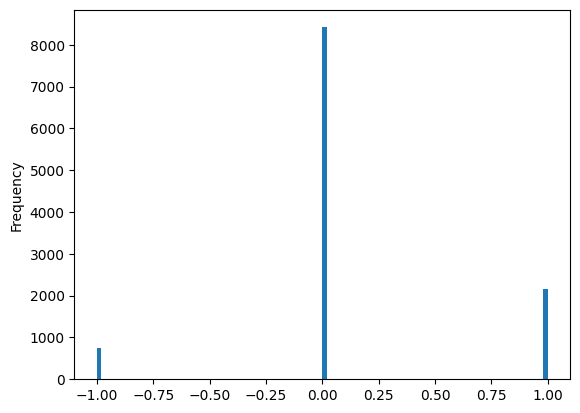

In [364]:
wikitq_train['diff'].plot.hist(bins=100)

In [ ]:
# predict which score would be higher (text vs image)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# remove rows with diff == 0
wikitq_train_ = wikitq_train[wikitq_train['diff'] != 0]
wikitq_test_ = wikitq_test[wikitq_test['diff'] != 0]

# question characteristics
wikitq_train_['question_length'] = wikitq_train_.question.apply(lambda x: len(x.split()))
wikitq_test_['question_length'] = wikitq_test_.question.apply(lambda x: len(x.split()))

# table characteristics
wikitq_train_['table_num_rows'] = wikitq_train_.table.apply(lambda x: len(x['rows']))
wikitq_train_['table_num_cols'] = wikitq_train_.table.apply(lambda x: len(x['header']))

wikitq_test_['table_num_rows'] = wikitq_test_.table.apply(lambda x: len(x['rows']))
wikitq_test_['table_num_cols'] = wikitq_test_.table.apply(lambda x: len(x['header']))

# TODO: answer characteristics
wikitq_train_['image_pred_length'] = wikitq_train_.image_pred.apply(lambda x: len(str(x).split()))
wikitq_train_['text_pred_length'] = wikitq_train_.text_pred.apply(lambda x: len(str(x).split()))

wikitq_test_['image_pred_length'] = wikitq_test_.image_pred.apply(lambda x: len(str(x).split()))
wikitq_test_['text_pred_length'] = wikitq_test_.text_pred.apply(lambda x: len(str(x).split()))

# label: 1 if text_score >= image_score, 0 otherwise
wikitq_train_['label'] = wikitq_train_['diff'].apply(lambda x: 1 if x>=0 else 0)

# features
X = wikitq_train_[['question_length','table_num_rows','table_num_cols']].values
y = wikitq_train_['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipykernel_3514/2504200566.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikitq_train_['question_length'] = wikitq_train_.question.apply(lambda x: len(x.split()))
/tmp/ipykernel_3514/2504200566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikitq_test_['question_length'] = wikitq_test_.question.apply(lambda x: len(x.split()))
/tmp/ipykernel_3514/2504200566.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

AttributeError: 'float' object has no attribute 'split'

In [360]:
# random forest classifier
clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred) 

y_pred = clf.predict(X_train)
accuracy_score(y_train, y_pred) 

# 0.660929

# another metric
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)

0.8771551724137931

In [359]:
# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
accuracy_score(y_train, y_pred)


0.8125

In [358]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
accuracy_score(y_train, y_pred)


0.7487068965517242

In [349]:
wikitq_test_.predicted_label.sum()

np.int64(322)

In [351]:
X_test_ = wikitq_test_[['question_length','table_num_rows','table_num_cols']].values
X_test_ = scaler.transform(X_test_)

In [354]:
# apply classifier and caculate the score

wikitq_test_['predicted_label'] = 0.0
wikitq_test_['predicted_label'] = clf.predict(X_test_)

f = lambda x: x['image_c1r1_score'] if x['predicted_label'] == 0 else x['text_score']
wikitq_test_['predicted_score'] = wikitq_test_.apply(f, axis=1)
wikitq_test_['predicted_score'].sum()
 
# 387.8
# random forest -> 207.2 / 1000
# xgboost -> 209.0 / 1000
# logistic -> 216.4 / 1000

/tmp/ipykernel_3514/2201871545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikitq_test_['predicted_label'] = 0.0
/tmp/ipykernel_3514/2201871545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikitq_test_['predicted_label'] = clf.predict(X_test_)
/tmp/ipykernel_3514/2201871545.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

np.float64(207.2)

In [ ]:
wikitq_test__ = wikitq_test[wikitq_test['diff'] == 0]
wikitq_test__['text_score'].sum() # 387.8

# total -> 216.4 + 387.8 = 604.2 / 1000

np.float64(387.79999999999995)

Feature ranking:
1. feature 1 (0.5593699310048456)
2. feature 0 (0.2766232261382802)
3. feature 2 (0.1640068428568741)


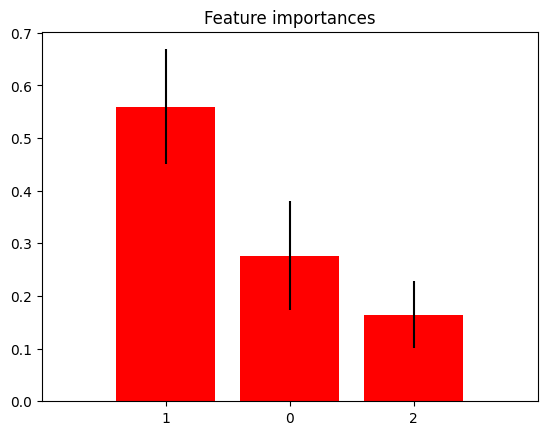

In [342]:
# feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. feature {indices[f]} ({importances[indices[f]]})")

# Plot the impurity-based feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
